In [1]:
# Imports
import os
import torch
import numpy as np
import re

# Training/Test Set Creation - to use later
from sklearn.model_selection import StratifiedShuffleSplit

# Dataset Creation
from torch.utils.data import Dataset, DataLoader, Subset
import torchvision.transforms as transforms
from sklearn.preprocessing import normalize

# Model Training and Definition
from torch import nn
from torch import optim
from torch.optim.lr_scheduler import CosineAnnealingLR, ReduceLROnPlateau
import trainutils

In [2]:
# Specify directories
frame_folder = "./data/frames"

# Create Training and Test Sets

## Load training data

In [4]:
# Construct X = folder names, y = the label

vf_list = os.listdir(frame_folder)

X_paths = [] # paths of segment folders
y = [] # designated label

for vf_folder in vf_list:
    
    # Create path to video
    vf_path = os.path.join(frame_folder, vf_folder)
    print("Current Video: "+ vf_folder)
    
    # Get individual segment folder
    segfolder_list = os.listdir(vf_path)
    
    # Check every segment folder
    for seg_folder in segfolder_list:
        
        #print(seg_folder)
        x_path = os.path.join(vf_path, seg_folder)
        #print(x_path)
        X_paths.append(x_path)
        
        # Extract class label from folder name
        label = int(seg_folder.split("_")[2])
        #print(label)
        y.append(label)

Current Video: video1
Current Video: video2
Current Video: video3
Current Video: video4


In [5]:
# Preview Data distribution
from collections import Counter
Counter(y)

Counter({1: 54, 2: 49, 4: 50, 5: 51, 8: 52, 9: 52, 0: 48, 3: 50, 6: 48, 7: 50})

In [6]:
# Split into training and test sets
splitter = StratifiedShuffleSplit(n_splits = 2, test_size = 0.1, random_state = 0)
train_set, test_set = next(splitter.split(X_paths, y))

# Training Set
train_X_paths = [X_paths[i] for i in train_set]
train_ys = [y[i] for i in train_set]
print("Training Set: ({0},{1})".format(len(train_X_paths), len(train_ys)))

# Test Set
test_X_paths = [X_paths[i] for i in test_set]
test_ys = [y[i] for i in test_set]
print("Test Set: ({0},{1})".format(len(test_X_paths), len(test_ys)))
#print(test_X_paths)

Training Set: (453,453)
Test Set: (51,51)


# Create Pytorch Dataset

In [7]:
# Set seeds for reproducibility
np.random.seed(4139)
torch.manual_seed(4139)

In [8]:
# Create Dataset Class
class SyncDataset(Dataset):
    
    def __init__(self, X, y, transform=None):
        self.transform = transform
        self.X = X
        self.y = y
    
    # Returns length
    def __len__(self):
        return len(self.X)
    
    # Returns X feature array and y value
    def __getitem__(self, idx):
        
        # Load npz file
        npz_path = self.X[idx]+'/features.npz'
        #print(npz_path)
        data = np.load(npz_path)
        X_feat = data['feature_array']
        
        # Transform if needed
        if self.transform:
            X_tensor = self.transform(X_feat).squeeze().float()
        else:
            # Convert X to tensor
            X_tensor = torch.from_numpy(X_feat).float()
        
        return X_tensor, self.y[idx] # y_tensor

In [9]:
# define normalization
class norm_per_keypt(object):
    """
    Rescale so features are between 0 and 1 for each subject

    """
    def __call__(self, sample):
        # squeeze tensor
        sample = sample.squeeze()
        # normalize
        sub1 = normalize(sample[:,0:56], axis=0)
        sub2 = normalize(sample[:,56:112], axis=0)
        sub3 = normalize(sample[:,112:168], axis=0)
        # recombine subjects
        scaled_sample = np.concatenate((sub1, sub2, sub3),axis=1)
        return scaled_sample

In [10]:
# Define Transformer - may need it for later, unused for now
transformer = transforms.Compose([
    norm_per_keypt(),
    transforms.ToTensor() # Add min-max scaler, or an normalizer
])

In [11]:
# Define Training Dataset 
training_dataset = SyncDataset(X = train_X_paths, y = train_ys, transform = transformer)
print(len(training_dataset))

# Define Test Dataset
testing_dataset = SyncDataset(X = test_X_paths, y = test_ys, transform = transformer)
print(len(testing_dataset))

453
51


In [12]:
# Grab a row to see contents
sample_X, sample_y = training_dataset[2]
sample_X.shape, sample_y

(torch.Size([20, 168]), 6)

# Define Data Loader  

Data Loader for extracting batches from the Pytorch Dataset during model training

In [13]:
def batch_collater(batch):
    X_batch, y_batch = list(zip(*batch))
    
    # Separate batch into X and y
    X_batch = [x for x in X_batch if len(x) > 0]
    y_batch = [torch.tensor(y) for y, x in zip(y_batch, X_batch) if len(x) > 0]
    
    # Convert into tensors
    X_tensor = torch.stack(X_batch)
    y_tensor = torch.stack(y_batch).long()
    
    return X_tensor, y_tensor

In [14]:
# Specify batch size
batch_size = 30

training_loader = DataLoader(training_dataset, batch_size = batch_size, shuffle=True, collate_fn=batch_collater)
testing_loader = DataLoader(testing_dataset, batch_size = batch_size, shuffle=True, collate_fn=batch_collater)

In [15]:
for xb, yb in training_loader:
    print(xb.shape, yb.shape)
    break

for xb, yb in testing_loader:
    print(xb.shape, yb.shape)
    break

torch.Size([30, 20, 168]) torch.Size([30])
torch.Size([30, 20, 168]) torch.Size([30])


# Model Definition 

In [16]:
class SyncRNN(nn.Module):
    
    def __init__(self, params_model):
        
        super(SyncRNN, self).__init__()
        
        # Import Model Parameters
        num_classes = params_model["num_classes"]
        dr_rate = params_model["dr_rate"] # dropout rate
        rnn_hidden_size = params_model["rnn_hidden_size"]
        rnn_num_layers = params_model["rnn_num_layers"]
        num_features = 168
        
        # Define Model Structure
        self.dropout = nn.Dropout(dr_rate) # - do we need this?
        self.rnn = nn.LSTM(num_features, rnn_hidden_size, rnn_num_layers)
        self.fc1 = nn.Linear(rnn_hidden_size, num_classes)
        
    def forward(self, x):
        
        # batch count, frame count, feature size
        batch_count, frame_count, feature_size = x.shape
        frame_idx = 0
        
        # Reshape the frame
        shaped_frame = x[:, frame_idx].view(batch_count, 1, feature_size)
        
        # Feed the first frame into the rnn
        output, (hn, cn) = self.rnn(shaped_frame)
        
        # Feed the rest of the frames 
        for frame_idx in range(1, frame_count):
            shaped_frame = x[:, frame_idx].view(batch_count, 1, feature_size)
            output, (hn, cn) = self.rnn(shaped_frame, (hn, cn))
        
        #output = self.dropout(output[:,-1])
        output = self.fc1(output)
        return output
        

In [17]:
# RNN Model Parameters
model_params = {
    "num_classes": 10,
    "dr_rate": 0.1,
    "rnn_num_layers": 1,
    "rnn_hidden_size": 500,
}
model = SyncRNN(model_params)

In [18]:
# Test Model with dummy input
with torch.no_grad():
    x = torch.zeros(1, 50, 168)
    y = model(x)
    print(y.shape) # should be [1,10]

torch.Size([1, 1, 10])


In [19]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

# Print Model Params
model = model.to(device)
model

cuda:0


SyncRNN(
  (dropout): Dropout(p=0.1, inplace=False)
  (rnn): LSTM(168, 500)
  (fc1): Linear(in_features=500, out_features=10, bias=True)
)

# Model Training  

Define loss function and optimizer to train the model

In [20]:
# Define Loss Function
loss_fn = nn.CrossEntropyLoss(reduction="sum")

In [21]:
# Define Optimizer (Adam)
optimizer = optim.Adam(model.parameters(), lr = 3e-3) #3e-5 # 3e-3

In [22]:
# Define LR Scheduler
lr_scheduler = ReduceLROnPlateau(optimizer, mode='min', factor= 0.05, patience = 5, verbose = 1)
os.makedirs("./models", exist_ok=True)

In [23]:
# Define Training Parameters - tweak this
train_params = {
    "num_epochs": 100, 
    "optimizer": optimizer,
    "loss_fn": loss_fn,
    "training_loader": training_loader,
    "testing_loader": testing_loader,
    "lr_scheduler": lr_scheduler,
    "weights_path": "./models/weights_kpf_norm.pt",
}

In [24]:
trained_model, loss_hist, metric_hist = trainutils.train_model(model, train_params)

Epoch 0/99, current_lr=0.003



Saved best model weights
Train Loss: 2.335647, Dev Loss: 2.310288, Accuracy: 9.80
----------
Epoch 1/99, current_lr=0.003



Saved best model weights
Train Loss: 2.310860, Dev Loss: 2.303742, Accuracy: 9.80
----------
Epoch 2/99, current_lr=0.003



Saved best model weights
Train Loss: 2.302674, Dev Loss: 2.302847, Accuracy: 11.76
----------
Epoch 3/99, current_lr=0.003



Saved best model weights
Train Loss: 2.299943, Dev Loss: 2.302213, Accuracy: 9.80
----------
Epoch 4/99, current_lr=0.003



Train Loss: 2.300068, Dev Loss: 2.303288, Accuracy: 5.88
----------
Epoch 5/99, current_lr=0.003



Train Loss: 2.295046, Dev Loss: 2.304188, Accuracy: 11.76
----------
Epoch 6/99, current_lr=0.003



Train Loss: 2.286717, Dev Loss: 2.312656, Accuracy: 9.80
----------
Epoch 7/99, current_lr=0.003



Train Loss: 2.287398, Dev Loss: 2.303658, Accuracy: 9.80
----------
Epoch 8/99, current_lr=0.003



Saved best model weights
Train Loss: 2.275993, Dev Loss: 2.300646, Accuracy: 9.80
----------
Epoch 9/99, current_lr=0.003



Saved best model weights
Train Loss: 2.263278, Dev Loss: 2.284093, Accuracy: 9.80
----------
Epoch 10/99, current_lr=0.003



Train Loss: 2.260238, Dev Loss: 2.295732, Accuracy: 3.92
----------
Epoch 11/99, current_lr=0.003



Train Loss: 2.245431, Dev Loss: 2.306326, Accuracy: 13.73
----------
Epoch 12/99, current_lr=0.003



Saved best model weights
Train Loss: 2.240331, Dev Loss: 2.282769, Accuracy: 7.84
----------
Epoch 13/99, current_lr=0.003



Saved best model weights
Train Loss: 2.219423, Dev Loss: 2.281943, Accuracy: 5.88
----------
Epoch 14/99, current_lr=0.003



Train Loss: 2.233923, Dev Loss: 2.283756, Accuracy: 5.88
----------
Epoch 15/99, current_lr=0.003



Train Loss: 2.215164, Dev Loss: 2.282675, Accuracy: 7.84
----------
Epoch 16/99, current_lr=0.003



Train Loss: 2.207540, Dev Loss: 2.286930, Accuracy: 7.84
----------
Epoch 17/99, current_lr=0.003



Saved best model weights
Train Loss: 2.199861, Dev Loss: 2.268506, Accuracy: 9.80
----------
Epoch 18/99, current_lr=0.003



Train Loss: 2.204891, Dev Loss: 2.282292, Accuracy: 11.76
----------
Epoch 19/99, current_lr=0.003



Train Loss: 2.176066, Dev Loss: 2.306491, Accuracy: 5.88
----------
Epoch 20/99, current_lr=0.003



Saved best model weights
Train Loss: 2.169858, Dev Loss: 2.245700, Accuracy: 11.76
----------
Epoch 21/99, current_lr=0.003



Train Loss: 2.149483, Dev Loss: 2.305903, Accuracy: 13.73
----------
Epoch 22/99, current_lr=0.003



Train Loss: 2.156144, Dev Loss: 2.285268, Accuracy: 1.96
----------
Epoch 23/99, current_lr=0.003



Train Loss: 2.143013, Dev Loss: 2.278537, Accuracy: 11.76
----------
Epoch 24/99, current_lr=0.003



Train Loss: 2.118709, Dev Loss: 2.302622, Accuracy: 5.88
----------
Epoch 25/99, current_lr=0.003



Train Loss: 2.111676, Dev Loss: 2.268818, Accuracy: 9.80
----------
Epoch 26/99, current_lr=0.003



Epoch    27: reducing learning rate of group 0 to 1.5000e-04.
Loading best model weights
Train Loss: 2.108843, Dev Loss: 2.246857, Accuracy: 1.96
----------
Epoch 27/99, current_lr=0.00015000000000000001



Train Loss: 2.132608, Dev Loss: 2.253985, Accuracy: 11.76
----------
Epoch 28/99, current_lr=0.00015000000000000001



Train Loss: 2.119517, Dev Loss: 2.256354, Accuracy: 11.76
----------
Epoch 29/99, current_lr=0.00015000000000000001



Train Loss: 2.122044, Dev Loss: 2.254988, Accuracy: 11.76
----------
Epoch 30/99, current_lr=0.00015000000000000001



Saved best model weights
Train Loss: 2.118522, Dev Loss: 2.230828, Accuracy: 9.80
----------
Epoch 31/99, current_lr=0.00015000000000000001



Train Loss: 2.127460, Dev Loss: 2.266965, Accuracy: 9.80
----------
Epoch 32/99, current_lr=0.00015000000000000001



Train Loss: 2.119749, Dev Loss: 2.251364, Accuracy: 7.84
----------
Epoch 33/99, current_lr=0.00015000000000000001



Train Loss: 2.123800, Dev Loss: 2.266625, Accuracy: 5.88
----------
Epoch 34/99, current_lr=0.00015000000000000001



Train Loss: 2.112983, Dev Loss: 2.256158, Accuracy: 1.96
----------
Epoch 35/99, current_lr=0.00015000000000000001



Train Loss: 2.114202, Dev Loss: 2.278919, Accuracy: 0.00
----------
Epoch 36/99, current_lr=0.00015000000000000001



Epoch    37: reducing learning rate of group 0 to 7.5000e-06.
Loading best model weights
Train Loss: 2.110204, Dev Loss: 2.273103, Accuracy: 7.84
----------
Epoch 37/99, current_lr=7.500000000000001e-06



Train Loss: 2.116065, Dev Loss: 2.278000, Accuracy: 0.00
----------
Epoch 38/99, current_lr=7.500000000000001e-06



Train Loss: 2.126333, Dev Loss: 2.240480, Accuracy: 7.84
----------
Epoch 39/99, current_lr=7.500000000000001e-06



Train Loss: 2.130758, Dev Loss: 2.292627, Accuracy: 3.92
----------
Epoch 40/99, current_lr=7.500000000000001e-06



Train Loss: 2.111704, Dev Loss: 2.264621, Accuracy: 5.88
----------
Epoch 41/99, current_lr=7.500000000000001e-06



Train Loss: 2.120235, Dev Loss: 2.254717, Accuracy: 5.88
----------
Epoch 42/99, current_lr=7.500000000000001e-06



Epoch    43: reducing learning rate of group 0 to 3.7500e-07.
Loading best model weights
Train Loss: 2.109318, Dev Loss: 2.260017, Accuracy: 3.92
----------
Epoch 43/99, current_lr=3.7500000000000006e-07



Train Loss: 2.114851, Dev Loss: 2.267697, Accuracy: 0.00
----------
Epoch 44/99, current_lr=3.7500000000000006e-07



Train Loss: 2.123215, Dev Loss: 2.282172, Accuracy: 5.88
----------
Epoch 45/99, current_lr=3.7500000000000006e-07



Train Loss: 2.129447, Dev Loss: 2.253281, Accuracy: 5.88
----------
Epoch 46/99, current_lr=3.7500000000000006e-07



Train Loss: 2.129776, Dev Loss: 2.284241, Accuracy: 3.92
----------
Epoch 47/99, current_lr=3.7500000000000006e-07



Train Loss: 2.119268, Dev Loss: 2.265054, Accuracy: 9.80
----------
Epoch 48/99, current_lr=3.7500000000000006e-07



Epoch    49: reducing learning rate of group 0 to 1.8750e-08.
Loading best model weights
Train Loss: 2.123002, Dev Loss: 2.249818, Accuracy: 11.76
----------
Epoch 49/99, current_lr=1.8750000000000006e-08



Train Loss: 2.124234, Dev Loss: 2.242687, Accuracy: 9.80
----------
Epoch 50/99, current_lr=1.8750000000000006e-08



Train Loss: 2.121237, Dev Loss: 2.245071, Accuracy: 7.84
----------
Epoch 51/99, current_lr=1.8750000000000006e-08



Saved best model weights
Train Loss: 2.123092, Dev Loss: 2.230648, Accuracy: 11.76
----------
Epoch 52/99, current_lr=1.8750000000000006e-08



Train Loss: 2.121149, Dev Loss: 2.273582, Accuracy: 5.88
----------
Epoch 53/99, current_lr=1.8750000000000006e-08



Train Loss: 2.122538, Dev Loss: 2.288659, Accuracy: 3.92
----------
Epoch 54/99, current_lr=1.8750000000000006e-08



Epoch    55: reducing learning rate of group 0 to 9.3750e-10.
Loading best model weights
Train Loss: 2.124903, Dev Loss: 2.253519, Accuracy: 7.84
----------
Epoch 55/99, current_lr=9.375000000000003e-10



Train Loss: 2.129186, Dev Loss: 2.260235, Accuracy: 9.80
----------
Epoch 56/99, current_lr=9.375000000000003e-10



Train Loss: 2.111082, Dev Loss: 2.253203, Accuracy: 11.76
----------
Epoch 57/99, current_lr=9.375000000000003e-10



Train Loss: 2.129079, Dev Loss: 2.288477, Accuracy: 5.88
----------
Epoch 58/99, current_lr=9.375000000000003e-10



Train Loss: 2.124038, Dev Loss: 2.280428, Accuracy: 9.80
----------
Epoch 59/99, current_lr=9.375000000000003e-10



Train Loss: 2.141173, Dev Loss: 2.270462, Accuracy: 13.73
----------
Epoch 60/99, current_lr=9.375000000000003e-10



Train Loss: 2.122765, Dev Loss: 2.245928, Accuracy: 3.92
----------
Epoch 61/99, current_lr=9.375000000000003e-10



Train Loss: 2.128962, Dev Loss: 2.260567, Accuracy: 9.80
----------
Epoch 62/99, current_lr=9.375000000000003e-10



Train Loss: 2.116265, Dev Loss: 2.248034, Accuracy: 11.76
----------
Epoch 63/99, current_lr=9.375000000000003e-10



Train Loss: 2.117188, Dev Loss: 2.277398, Accuracy: 11.76
----------
Epoch 64/99, current_lr=9.375000000000003e-10



Train Loss: 2.120626, Dev Loss: 2.273361, Accuracy: 7.84
----------
Epoch 65/99, current_lr=9.375000000000003e-10



Train Loss: 2.115701, Dev Loss: 2.258769, Accuracy: 7.84
----------
Epoch 66/99, current_lr=9.375000000000003e-10



Train Loss: 2.112876, Dev Loss: 2.266355, Accuracy: 5.88
----------
Epoch 67/99, current_lr=9.375000000000003e-10



Train Loss: 2.124365, Dev Loss: 2.249342, Accuracy: 5.88
----------
Epoch 68/99, current_lr=9.375000000000003e-10



Train Loss: 2.111508, Dev Loss: 2.272462, Accuracy: 7.84
----------
Epoch 69/99, current_lr=9.375000000000003e-10



Train Loss: 2.126824, Dev Loss: 2.254801, Accuracy: 9.80
----------
Epoch 70/99, current_lr=9.375000000000003e-10



Train Loss: 2.122889, Dev Loss: 2.267271, Accuracy: 9.80
----------
Epoch 71/99, current_lr=9.375000000000003e-10



Train Loss: 2.126034, Dev Loss: 2.265362, Accuracy: 7.84
----------
Epoch 72/99, current_lr=9.375000000000003e-10



Train Loss: 2.122896, Dev Loss: 2.274466, Accuracy: 9.80
----------
Epoch 73/99, current_lr=9.375000000000003e-10



Train Loss: 2.125204, Dev Loss: 2.257824, Accuracy: 5.88
----------
Epoch 74/99, current_lr=9.375000000000003e-10



Train Loss: 2.129913, Dev Loss: 2.265746, Accuracy: 7.84
----------
Epoch 75/99, current_lr=9.375000000000003e-10



Train Loss: 2.121802, Dev Loss: 2.253746, Accuracy: 5.88
----------
Epoch 76/99, current_lr=9.375000000000003e-10



Train Loss: 2.118297, Dev Loss: 2.279495, Accuracy: 5.88
----------
Epoch 77/99, current_lr=9.375000000000003e-10



Train Loss: 2.124438, Dev Loss: 2.256757, Accuracy: 11.76
----------
Epoch 78/99, current_lr=9.375000000000003e-10



Train Loss: 2.123069, Dev Loss: 2.265627, Accuracy: 11.76
----------
Epoch 79/99, current_lr=9.375000000000003e-10



Train Loss: 2.117877, Dev Loss: 2.269597, Accuracy: 11.76
----------
Epoch 80/99, current_lr=9.375000000000003e-10



Train Loss: 2.112927, Dev Loss: 2.283505, Accuracy: 7.84
----------
Epoch 81/99, current_lr=9.375000000000003e-10



Train Loss: 2.125555, Dev Loss: 2.243904, Accuracy: 7.84
----------
Epoch 82/99, current_lr=9.375000000000003e-10



Train Loss: 2.119570, Dev Loss: 2.276239, Accuracy: 3.92
----------
Epoch 83/99, current_lr=9.375000000000003e-10



Train Loss: 2.116792, Dev Loss: 2.265355, Accuracy: 5.88
----------
Epoch 84/99, current_lr=9.375000000000003e-10



Train Loss: 2.125731, Dev Loss: 2.278246, Accuracy: 13.73
----------
Epoch 85/99, current_lr=9.375000000000003e-10



Train Loss: 2.123641, Dev Loss: 2.295852, Accuracy: 5.88
----------
Epoch 86/99, current_lr=9.375000000000003e-10



Train Loss: 2.122016, Dev Loss: 2.271168, Accuracy: 13.73
----------
Epoch 87/99, current_lr=9.375000000000003e-10



Train Loss: 2.123139, Dev Loss: 2.253072, Accuracy: 9.80
----------
Epoch 88/99, current_lr=9.375000000000003e-10



Train Loss: 2.116788, Dev Loss: 2.271647, Accuracy: 11.76
----------
Epoch 89/99, current_lr=9.375000000000003e-10



Train Loss: 2.120426, Dev Loss: 2.253769, Accuracy: 9.80
----------
Epoch 90/99, current_lr=9.375000000000003e-10



Train Loss: 2.123949, Dev Loss: 2.250646, Accuracy: 7.84
----------
Epoch 91/99, current_lr=9.375000000000003e-10



Train Loss: 2.119191, Dev Loss: 2.280034, Accuracy: 9.80
----------
Epoch 92/99, current_lr=9.375000000000003e-10



Train Loss: 2.123141, Dev Loss: 2.251461, Accuracy: 11.76
----------
Epoch 93/99, current_lr=9.375000000000003e-10



Train Loss: 2.128970, Dev Loss: 2.258627, Accuracy: 9.80
----------
Epoch 94/99, current_lr=9.375000000000003e-10



Train Loss: 2.125502, Dev Loss: 2.263412, Accuracy: 1.96
----------
Epoch 95/99, current_lr=9.375000000000003e-10



Train Loss: 2.118187, Dev Loss: 2.273934, Accuracy: 3.92
----------
Epoch 96/99, current_lr=9.375000000000003e-10



Train Loss: 2.129051, Dev Loss: 2.256424, Accuracy: 3.92
----------
Epoch 97/99, current_lr=9.375000000000003e-10



Train Loss: 2.118940, Dev Loss: 2.256134, Accuracy: 3.92
----------
Epoch 98/99, current_lr=9.375000000000003e-10



Train Loss: 2.113238, Dev Loss: 2.248050, Accuracy: 7.84
----------
Epoch 99/99, current_lr=9.375000000000003e-10



Train Loss: 2.135000, Dev Loss: 2.253566, Accuracy: 7.84
----------


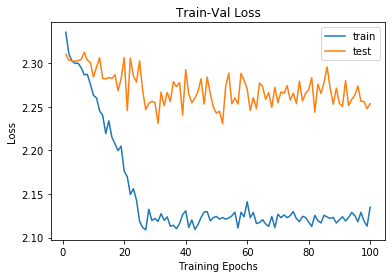

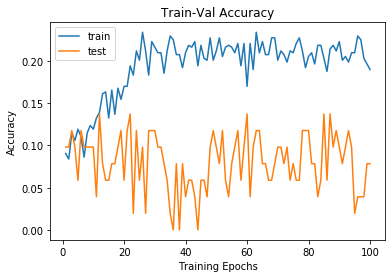

In [25]:
trainutils.plot_loss(loss_hist, metric_hist)